# STAT207 Mini-Project #2 - Temperature Predicting Weather Model


Conan Zhang

In [1]:
#Imports!
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression
import warnings

## 1. Introduction

#### Research Question
In this report, let's take a look at sample weather data taken across the web. The goal of this project is to build a predicitve model that will perform the best when predicting Temperature for new weather datasets. Using dew point temperature, relative humidity, wind speed, visibility, atmospheric pressure, and the type of weather present, the average person can better visualize weather patterns and predict forecasts for future weather conditions. Additionally, with our best model, we can explore the nature of the relationships between all our weather variables to yield reliable interpretative insights in our analysis.

#### Research Motivation
Weather plays a crucial role in our daily lives; what we wear in the morning, what transportation we utilize, and what activities we do outside are all circumstances weather has a say in. Essentially, by building a predictive model that predicts Temperature for new weather datasets, the average person can utilize temperature forecasts to effectively make informed decisions within their life. For example, in agriculture, farmers can rely on forecasts and subsequent temperature forecasts to make informed decisions on crop planting, irrigation, harvesting to maximize crop yields and minimize losses from unfavorable temperatures.

## 2. Dataset Discussion

#### Defininitions
Dew Point Temperature: temperature the air needs to be cooled to in order to achieve a relative humidity of 100% (Celsius) 
<br> Relative Humidity: amount of atmospheric moisture present relative over the amount that would be present if the air were saturated (%)
<br> Wind Speed: rate at which air is moving (kilometers per hour)
<br> Visibility: a measure of the horizontal opacity of the atmosphere at the point of observation (km)
<br> Atmospheric Pressure: force exerted on a surface by the air above it as gravity pulls it to Earth. standard is 101.325 kPa (kPa)

#### Dataset Display

In [2]:
df = pd.read_csv('Weather Data.csv')
df.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [3]:
df.shape[0]

8784

#### Dataset Source
This dataset was taken and downloaded from Kaggle on October 23rd, 2023. (https://www.kaggle.com/datasets/bhanupratapbiswas/weather-data).

## 3. Dataset Cleaning

#### Initial Cleaning
First, we'd like to drop the Date/Time column from our analysis to consider a fair prediction of weather forecast. While the time of day could be a direct indication to general temperature trends, we want to use other unique weather metrics to build our model in predicting resulting Temperature. Variables in the original dataframe have also been renamed to better illustrate their meaning.

In [4]:
df1 = df.drop(['Date/Time'], axis=1)

In [5]:
df2 = df1.rename(columns={'Dew Point Temp_C':'Dew_Point_Temp_C', 'Rel Hum_%':'Relative_Humidity_Percent', 'Wind Speed_km/h':'Wind_Speed_kmh', 'Press_kPa':'Atmospheric_Pressure_kPA'})


In [6]:
df2.head()

,Temp_C,Dew_Point_Temp_C,Relative_Humidity_Percent,Wind_Speed_kmh,Visibility_km,Atmospheric_Pressure_kPA,Weather
0,-1.8,-3.9,86,4,8.0,101.24,Fog
1,-1.8,-3.7,87,4,8.0,101.24,Fog
2,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,-1.5,-3.3,88,7,4.8,101.23,Fog


#### Missing Values
All of the variable dtypes make sense illustrating that there are no implicit missing values in our dataframe. There are also no explicit missing values as all of our rows in the dataset contain identifiable information.

In [7]:
df2.dtypes

Temp_C                       float64
Dew_Point_Temp_C             float64
Relative_Humidity_Percent      int64
Wind_Speed_kmh                 int64
Visibility_km                float64
Atmospheric_Pressure_kPA     float64
Weather                       object
dtype: object

In [8]:
df2.isna().sum()

Temp_C                       0
Dew_Point_Temp_C             0
Relative_Humidity_Percent    0
Wind_Speed_kmh               0
Visibility_km                0
Atmospheric_Pressure_kPA     0
Weather                      0
dtype: int64

#### Weather Condition Cutoffs
Next, it would be reasonable to consider only popular types of weather forecasts given our dataset. Looking at the value counts, only including weather descriptions of Fog (150 data points) and higher would be preferable in building our model. This way, we would have enough data points to generalize to future datasets.

In [9]:
df2['Weather'].value_counts()

Mainly Clear                               2106
Mostly Cloudy                              2069
Cloudy                                     1728
Clear                                      1326
Snow                                        390
Rain                                        306
Rain Showers                                188
Fog                                         150
Rain,Fog                                    116
Drizzle,Fog                                  80
Snow Showers                                 60
Drizzle                                      41
Snow,Fog                                     37
Snow,Blowing Snow                            19
Rain,Snow                                    18
Thunderstorms,Rain Showers                   16
Haze                                         16
Drizzle,Snow,Fog                             15
Freezing Rain                                14
Freezing Drizzle,Snow                        11
Freezing Drizzle                        

In [10]:
counts = df2['Weather'].value_counts()
df3 = df2[df2['Weather'].isin(counts.index[counts >= 149])]
df3['Weather'].value_counts()

Mainly Clear     2106
Mostly Cloudy    2069
Cloudy           1728
Clear            1326
Snow              390
Rain              306
Rain Showers      188
Fog               150
Name: Weather, dtype: int64

#### Single Variable Outlier Inspection
Looking at each of our explanatory variables, the boxplots suggest there to be outliers present for alot of our explanatory variables. For Wind Speed, we will remove all wind speeds greater than 60 km/hr as going outside or outdoor activities become quite difficult at that speed, thus temperature may not be as important compared to wind, rain, or coverage (dropped 3 rows). For visibility, we will remove all data points with the high outlier of ~48 km, due to the extreme nature of the value. It can be suggestive that with high visibility, the weather outside will be clear, making the temperature "good" or favorable for being outdoors (dropped 2012 rows). For atmospheric pressure, we will include all the datapoints as we would like to represent a range of atmospheric pressures which could vary based on altitude and thus affect temperature. After running .value_counts post cleaning, each of our weather conditions still have an ample amount of data points to construct our model.

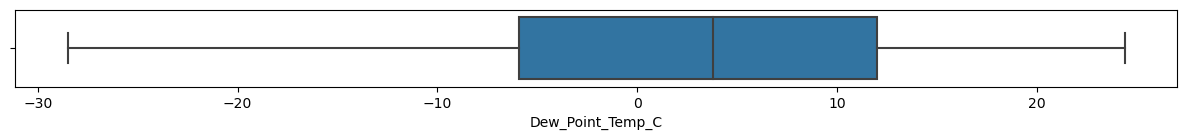

In [11]:
plt.figure(figsize=(15,1))
sns.boxplot(x='Dew_Point_Temp_C', data=df3)
plt.show()

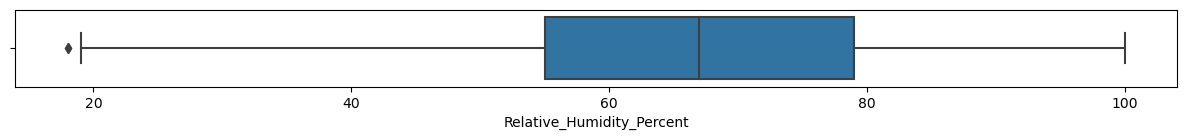

In [12]:
plt.figure(figsize=(15,1))
sns.boxplot(x='Relative_Humidity_Percent', data=df3)
plt.show()

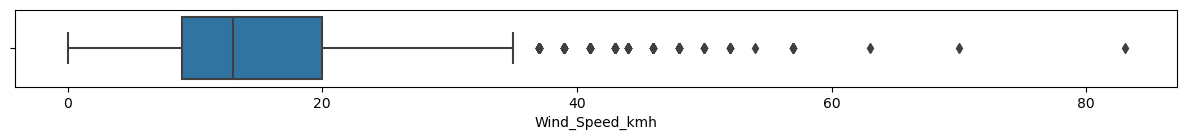

In [13]:
plt.figure(figsize=(15,1))
sns.boxplot(x='Wind_Speed_kmh', data=df3)
plt.show()

In [14]:
df4 = df3[df3['Wind_Speed_kmh'] < 60]
df3.shape[0]-df4.shape[0]

3

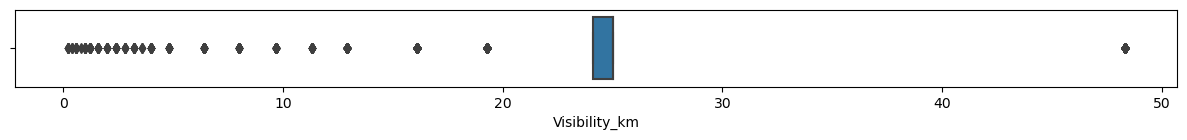

In [15]:
plt.figure(figsize=(15,1))
sns.boxplot(x='Visibility_km', data=df4)
plt.show()

In [16]:
df5 = df4[df4['Visibility_km'] < 40]
df4.shape[0]-df5.shape[0]

2012

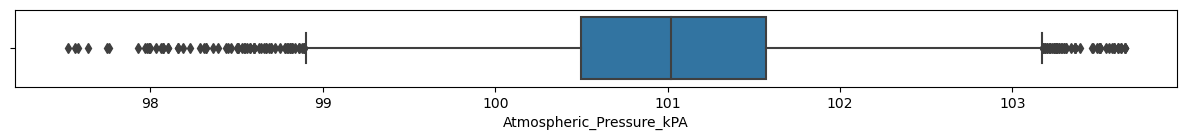

In [17]:
plt.figure(figsize=(15,1))
sns.boxplot(x='Atmospheric_Pressure_kPA', data=df5)
plt.show()

In [18]:
df5['Weather'].value_counts()

Cloudy           1505
Mostly Cloudy    1465
Mainly Clear     1235
Clear            1013
Snow              390
Rain              304
Rain Showers      186
Fog               150
Name: Weather, dtype: int64

#### Categorical Variable Inspection
Finishing cleaning our numerical explanatory variables and now displaying the weather conditions that we considered, the boxplots indicate a strong association between weather and temperature as all the individual box plots have different medians, different IQRs, and ranges.

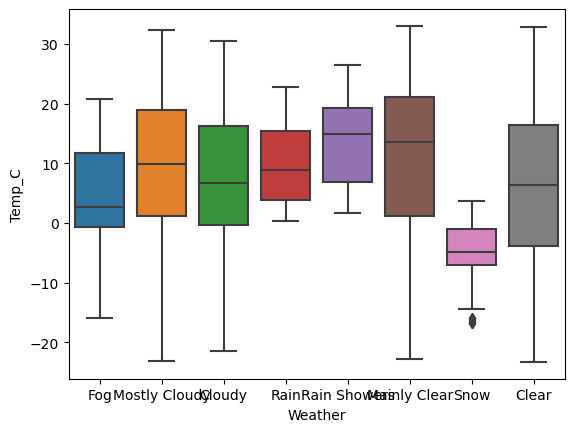

In [19]:
sns.boxplot(x='Weather', y='Temp_C', data = df5)
plt.show()

## 4. Preliminary Analysis

#### Variable Transformations
While Dew Point Temperature has a strong correlation with Temperature, the rest of the numerical explanatory variables have no sort of linear correlation with Temperature or any other type of trend (exponential, log, inverse, etc.). Thus, these variables have no apparent capability to be transformed.

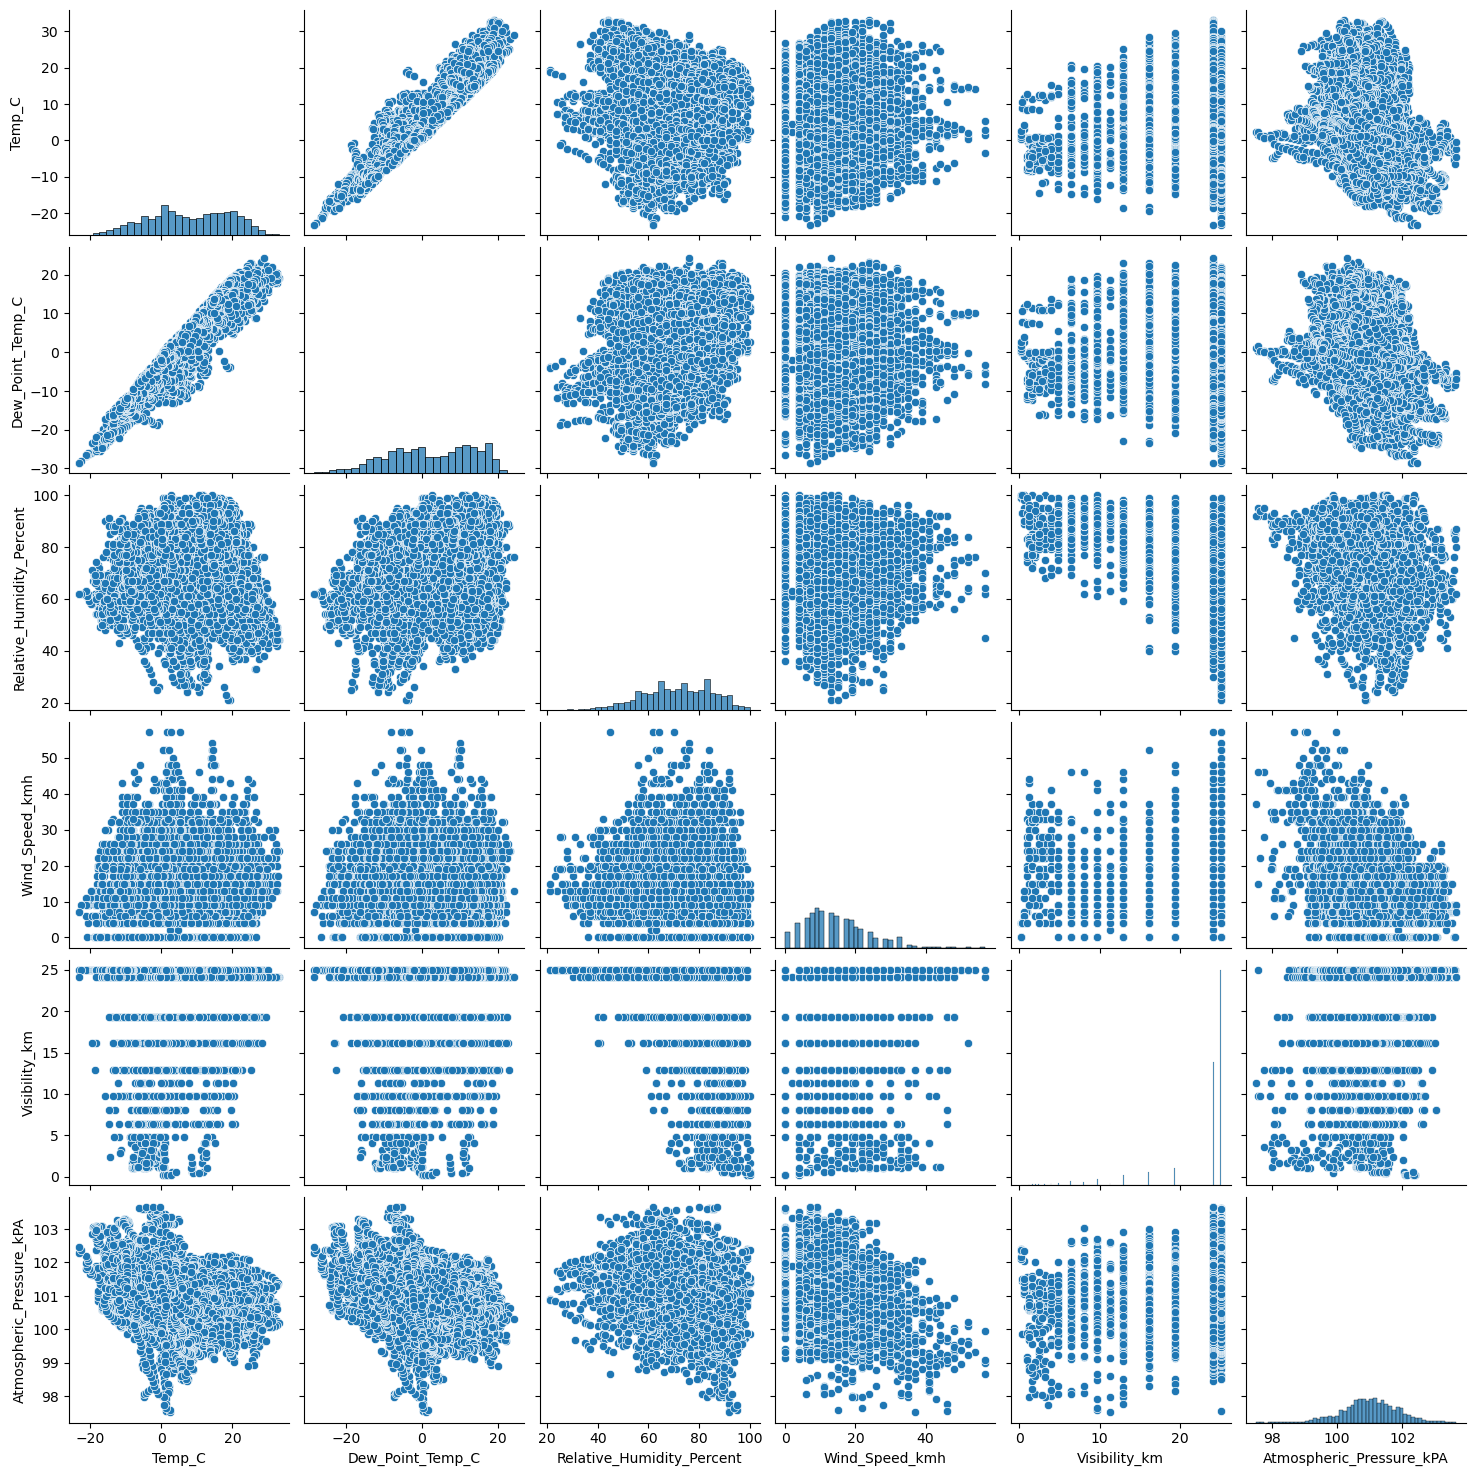

In [20]:
sns.pairplot(df5[['Temp_C','Dew_Point_Temp_C','Relative_Humidity_Percent','Wind_Speed_kmh','Visibility_km','Atmospheric_Pressure_kPA']])
plt.show()

#### Linearity Assumption
Because the residual plot has a somewhat even distribution of +/- residuals, a linear regression model would sort of be the most suitable model to accurately describe this dataset. Although our model underpredicted a few data points, the overwhelming bulk of residuals are evenly distributed in each section of the plot, making a linear regression model okay to use. Using this model, an R squared value of ~0.99813 was fitted to the dataset, suggesting that alot of the variability of Temperature can be explained by the explanatory variables, which is a good indicator for predicting future datasets.

In [21]:
full_model = smf.ols('Temp_C~Dew_Point_Temp_C+Relative_Humidity_Percent+Wind_Speed_kmh+Visibility_km+Atmospheric_Pressure_kPA', data = df5).fit()

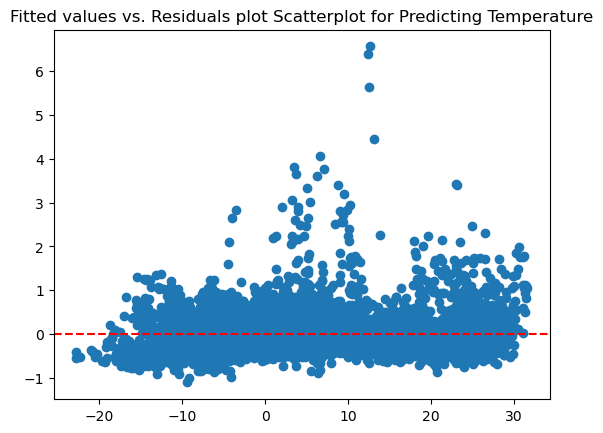

In [22]:
plt.title('Fitted values vs. Residuals plot Scatterplot for Predicting Temperature')
plt.scatter(full_model.fittedvalues, full_model.resid)
plt.axhline(y=0,color='r',linestyle='--')
plt.show()

In [23]:
full_model.rsquared

0.9981344040421689

#### Interaction Terms
In varying each numerical explanatory variable by Weather and plotting the respective Temperature, there are strong interaction effects between (Relative_Humidity_Percent and Weather), (Wind_Speed_kmh and Weather), and (Atmospheric_Pressure_kPA and Weather). This is due to the varying slopes for the different weather conditions within each lmplot. Fog and Snow weather conditions both have drastically different slopes suggesting these conditions affect how Relative Humidity and Wind Speed affect Temperature.

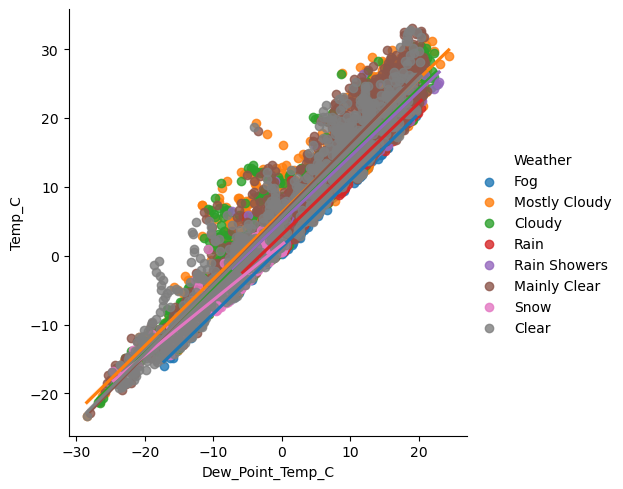

In [24]:
sns.lmplot(x='Dew_Point_Temp_C', y='Temp_C', hue='Weather', data = df5)
plt.show()

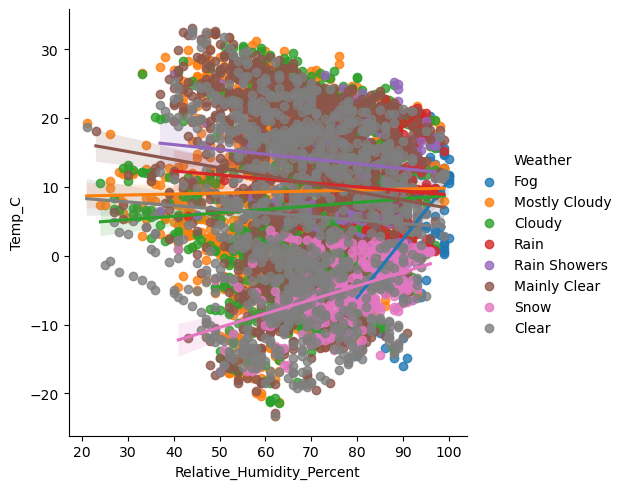

In [25]:
sns.lmplot(x='Relative_Humidity_Percent', y='Temp_C', hue='Weather', data = df5)
plt.show()

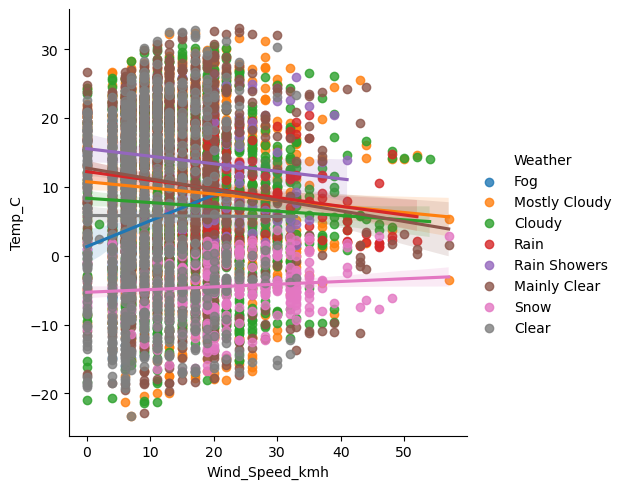

In [26]:
sns.lmplot(x='Wind_Speed_kmh', y='Temp_C', hue='Weather', data = df5)
plt.show()

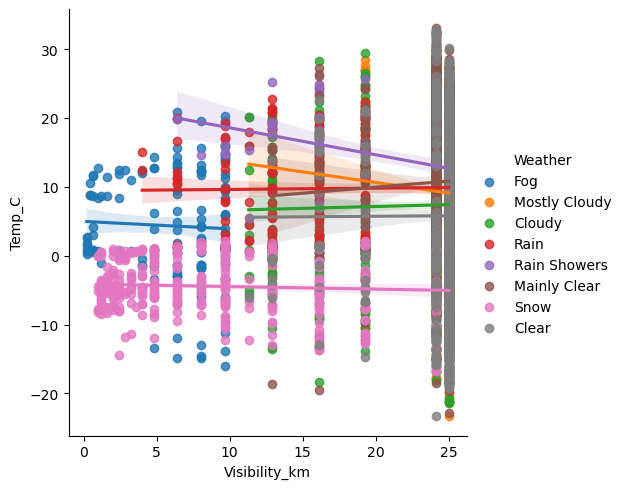

In [27]:
sns.lmplot(x='Visibility_km', y='Temp_C', hue='Weather', data = df5)
plt.show()

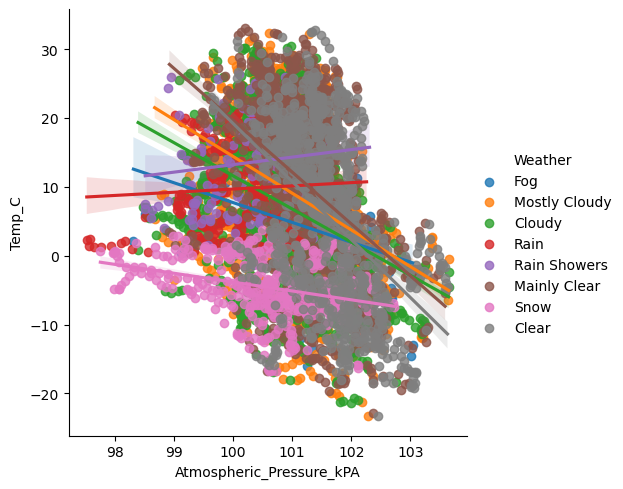

In [28]:
sns.lmplot(x='Atmospheric_Pressure_kPA', y='Temp_C', hue='Weather', data = df5)
plt.show()

## 5. Predictive Models

#### Model Preparation

In [29]:
df_num = df5[['Temp_C','Dew_Point_Temp_C','Relative_Humidity_Percent','Wind_Speed_kmh','Visibility_km','Atmospheric_Pressure_kPA']]

In [30]:
df_cat = df5[['Weather']]
df_cat = pd.get_dummies(df_cat, drop_first=True, dtype=int)

In [31]:
df_cat = df_cat.rename(columns={'Weather_Mainly Clear':'Weather_Mainly_Clear','Weather_Mostly Cloudy':'Weather_Mostly_Cloudy','Weather_Rain Showers':'Weather_Rain_Showers'})

In [32]:
df6 = pd.concat([df_num, df_cat], axis=1)
df6.head()

,Temp_C,Dew_Point_Temp_C,Relative_Humidity_Percent,Wind_Speed_kmh,Visibility_km,Atmospheric_Pressure_kPA,Weather_Cloudy,Weather_Fog,Weather_Mainly_Clear,Weather_Mostly_Cloudy,Weather_Rain,Weather_Rain_Showers,Weather_Snow
0,-1.8,-3.9,86,4,8.0,101.24,0,1,0,0,0,0,0
1,-1.8,-3.7,87,4,8.0,101.24,0,1,0,0,0,0,0
4,-1.5,-3.3,88,7,4.8,101.23,0,1,0,0,0,0,0
5,-1.4,-3.3,87,9,6.4,101.27,0,1,0,0,0,0,0
6,-1.5,-3.1,89,7,6.4,101.29,0,1,0,0,0,0,0


In [33]:
df_train,df_test = train_test_split(df6, test_size = 0.2,random_state = 1)

#### Scaling: Z-Score Transformation

In [34]:
scaler = StandardScaler()
scaler_expl_vars = scaler.fit_transform(df_train)
df_train_s = pd.DataFrame(scaler_expl_vars, columns = df_train.columns)
df_train_s.head()

,Temp_C,Dew_Point_Temp_C,Relative_Humidity_Percent,Wind_Speed_kmh,Visibility_km,Atmospheric_Pressure_kPA,Weather_Cloudy,Weather_Fog,Weather_Mainly_Clear,Weather_Mostly_Cloudy,Weather_Rain,Weather_Rain_Showers,Weather_Snow
0,0.665999,1.036987,1.507378,0.637458,-0.616071,-0.605890,-0.565797,-0.154824,-0.492611,-0.554083,-0.225573,5.744563,-0.259354
1,1.144804,1.386092,0.863341,-0.166859,-0.616071,-0.151247,-0.565797,-0.154824,-0.492611,1.804783,-0.225573,-0.174078,-0.259354
2,0.979399,1.081744,0.362423,-0.166859,0.460869,0.373341,-0.565797,-0.154824,-0.492611,1.804783,-0.225573,-0.174078,-0.259354
3,-0.369959,-0.216209,0.505542,0.637458,0.290826,1.131080,-0.565797,-0.154824,-0.492611,1.804783,-0.225573,-0.174078,-0.259354
4,-1.562617,-1.335134,0.934900,-0.971177,0.460869,0.303396,1.767417,-0.154824,-0.492611,-0.554083,-0.225573,-0.174078,-0.259354


In [35]:
scaler_expl_vars1 = scaler.transform(df_test)
df_test_s = pd.DataFrame(scaler_expl_vars1, columns = df_test.columns)
df_test_s.head()

,Temp_C,Dew_Point_Temp_C,Relative_Humidity_Percent,Wind_Speed_kmh,Visibility_km,Atmospheric_Pressure_kPA,Weather_Cloudy,Weather_Fog,Weather_Mainly_Clear,Weather_Mostly_Cloudy,Weather_Rain,Weather_Rain_Showers,Weather_Snow
0,0.213312,0.437243,0.863341,2.131191,0.460869,-0.349425,1.767417,-0.154824,-0.492611,-0.554083,-0.225573,-0.174078,-0.259354
1,0.726938,1.171258,1.865176,-0.166859,0.460869,-0.804068,-0.565797,-0.154824,-0.492611,-0.554083,-0.225573,5.744563,-0.259354
2,-1.632261,-1.702142,-0.496293,-0.166859,0.460869,2.599927,-0.565797,-0.154824,2.030000,-0.554083,-0.225573,-0.174078,-0.259354
3,-1.405917,-1.335134,0.147744,-0.626469,0.460869,0.979532,-0.565797,-0.154824,-0.492611,-0.554083,-0.225573,-0.174078,-0.259354
4,-1.144751,-1.039738,0.290863,0.292751,0.290826,0.198479,-0.565797,-0.154824,2.030000,-0.554083,-0.225573,-0.174078,-0.259354


### 5.1. Non-Regularized Linear Regression Full Model

In [36]:
nonreg_full_model = smf.ols('Temp_C~Dew_Point_Temp_C+Relative_Humidity_Percent+Wind_Speed_kmh+Atmospheric_Pressure_kPA+Weather_Cloudy+Weather_Fog+Weather_Mainly_Clear+Weather_Rain+Weather_Rain_Showers+Weather_Snow', data=df_train_s).fit()

In [37]:
y_test = df_test_s['Temp_C']
y_pred_test = nonreg_full_model.predict(df_test_s)
r2_score(y_test,y_pred_test)

0.9980511128022443

### 5.2. Non-Regularized Linear Regression Full Model with Interaction Terms

In [38]:
nonreg_full_model1 = smf.ols('Temp_C~Dew_Point_Temp_C+Relative_Humidity_Percent+Wind_Speed_kmh+Atmospheric_Pressure_kPA+Weather_Cloudy+Weather_Fog+Weather_Mainly_Clear+Weather_Rain+Weather_Rain_Showers+Weather_Snow+ Weather_Fog*Relative_Humidity_Percent + Weather_Snow*Relative_Humidity_Percent + Weather_Cloudy*Relative_Humidity_Percent + Weather_Mostly_Cloudy*Relative_Humidity_Percent  + Weather_Fog*Wind_Speed_kmh', data=df_train_s).fit()

In [39]:
y_pred_test1 = nonreg_full_model1.predict(df_test_s)
r2_score(y_test,y_pred_test1)

0.9981318585907619

### 5.3. Regularization

In [40]:
X_train = df_train.drop(['Temp_C'], axis = 1)
X_test = df_test.drop(['Temp_C'], axis = 1)
y_train = df_train['Temp_C']
y_test = df_test['Temp_C']

In [41]:
#Lasso
warnings.filterwarnings('ignore')
lasso_list = []
for i in np.arange(0,0.8005,0.005):
    lasso_mod = Lasso(alpha = i, max_iter = 10000)
    lasso_mod.fit(X_train,y_train)
    R_sq = lasso_mod.score(X_test,y_test)
    lasso_list.append([i,R_sq])
df_lasso = pd.DataFrame(lasso_list, columns=['lambda', 'test_r2'])
df_lasso.sort_values('test_r2',ascending = False).head(1)

,lambda,test_r2
0,0.0,0.998145


In [42]:
lasso_mod_best = Lasso(alpha = 0, max_iter = 10000)
lasso_mod_best.fit(X_train,y_train)
lasso_mod_best.score(X_test,y_test)

0.9981445179788334

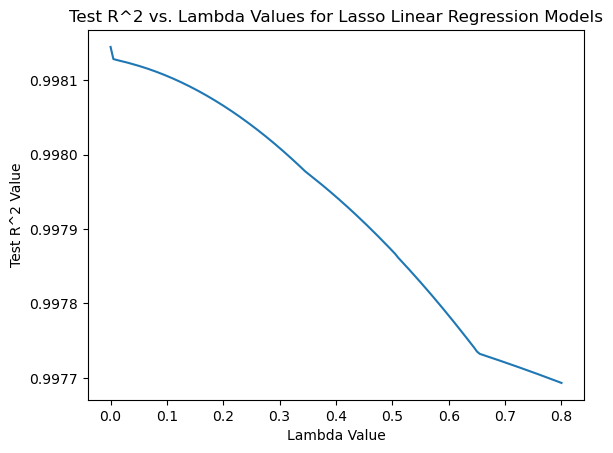

In [43]:
plt.title('Test R^2 vs. Lambda Values for Lasso Linear Regression Models')
plt.plot(df_lasso['lambda'].values, df_lasso['test_r2'].values)
plt.ylabel('Test R^2 Value')
plt.xlabel('Lambda Value')
plt.show()

In [44]:
#Ridge 
warnings.filterwarnings('ignore')
ridge_list = []
for i in np.arange(0,501,1):
    ridge_mod = Ridge(alpha = i, max_iter = 10000)
    ridge_mod.fit(X_train,y_train)
    R_sq = ridge_mod.score(X_test,y_test)
    ridge_list.append([i,R_sq])
df_ridge = pd.DataFrame(ridge_list, columns=['lambda', 'test_r2'])
df_ridge.sort_values('test_r2',ascending = False).head(1)

,lambda,test_r2
11,11,0.998145


In [45]:
ridge_mod_best = Ridge(alpha = 11, max_iter = 10000)
ridge_mod_best.fit(X_train,y_train)
ridge_mod_best.score(X_test,y_test)

0.998144593274445

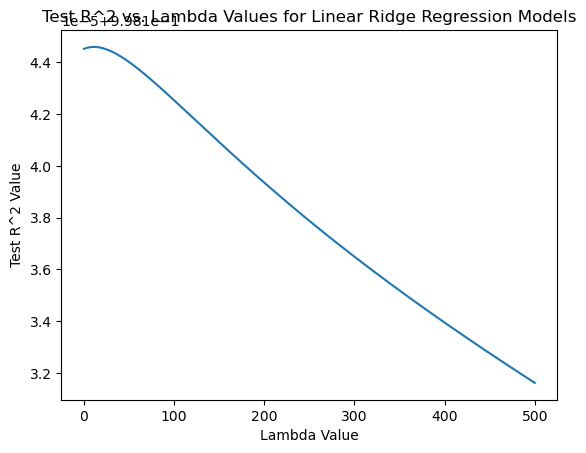

In [46]:
plt.title('Test R^2 vs. Lambda Values for Linear Ridge Regression Models')
plt.plot(df_ridge['lambda'].values, df_ridge['test_r2'].values)
plt.ylabel('Test R^2 Value')
plt.xlabel('Lambda Value')
plt.show()

In [52]:
#Elastic Net 
warnings.filterwarnings('ignore')
en_list = []
for i in np.arange(0,0.8005,0.005):
    en_mod = ElasticNet(alpha = i, l1_ratio = 0.7,max_iter = 10000)
    en_mod.fit(X_train,y_train)
    R_sq = en_mod.score(X_test,y_test)
    en_list.append([i,R_sq])
df_en = pd.DataFrame(en_list, columns=['lambda', 'test_r2'])
df_en.sort_values('test_r2',ascending = False).head(1)

,lambda,test_r2
0,0.0,0.998145


In [48]:
en_mod_best = ElasticNet(alpha = 0, l1_ratio = 0.7, max_iter = 10000)
en_mod_best.fit(X_train,y_train)
en_mod_best.score(X_test,y_test)

0.9981445179788334

## 6. Best Model Discussion

#### Best Models
Because Lasso, Ridge, and Elastic Net Regularization all found a similar highest test R^2 value of 0.998145, they would all be considered "best" models. However, our experimental best model suggests the Ridge Regression model with lambda=11 with a R^2 value of 0.998144593274445 to be the best fit which is only ~0.00000007 test R^2 better than our Lasso and Net Elastic models.

#### Best Equation (Ridge)
Predicted Temp_C = 24.802687433138217 + 1.049236[Dew_Point_Temp_C] - 0.231952[Relative_Humidity_Percent] - 0.005583[Wind_Speed_kmh] - 0.034383[Visibility_km] - 0.023686[Atmospheric_Pressure_kPA] - 0.039883[Weather_Cloudy] + 0.211737[Weather_Fog] - 0.048622[Weather_Mainly_Clear] - 0.048743[Weather_Mostly_Cloudy] + 0.056868[Weather_Rain] - 0.103609[Weather_Rain_Showers] - 0.094192[Weather_Snow]

In [49]:
df_all_slopes = pd.DataFrame({'lasso_mod_best': lasso_mod_best.coef_.T,
                             'ridge_mod_best': ridge_mod_best.coef_.T,
                             'elasticnet_mod_best': en_mod_best.coef_.T}, index = X_train.columns)
df_all_slopes

,lasso_mod_best,ridge_mod_best,elasticnet_mod_best
Dew_Point_Temp_C,1.049236,1.049216,1.049236
Relative_Humidity_Percent,-0.231952,-0.231926,-0.231952
Wind_Speed_kmh,-0.005583,-0.005635,-0.005583
Visibility_km,-0.034383,-0.034802,-0.034383
Atmospheric_Pressure_kPA,-0.023686,-0.023190,-0.023686
Weather_Cloudy,-0.039883,-0.038328,-0.039883
Weather_Fog,0.211737,0.187110,0.211737
Weather_Mainly_Clear,-0.048622,-0.046603,-0.048622
Weather_Mostly_Cloudy,-0.048743,-0.046596,-0.048743
Weather_Rain,0.056868,0.054031,0.056868


In [50]:
ridge_mod_best.intercept_

24.802687433138217

#### Dataset Fit
Because the test R^2 value is so high (~0.998) and so close to 1.00, this model was able to predict the test dataset Temp_C values with high precision. Thus, this model is an overall good fit.

#### Overfitting Explanatory Variables
All of the explanatory variable slopes for our best ridge regression model appear to be similar in value to our non-regularized full model. This suggests that our variables did not have much predictive power to begin with and were not overfitting our model in the first place. 

#### Multicollinearity
No, there is no explanatory variable pair for all of the explanatory variables that suggests collinearity as none of the pairs have a correlation coefficient of 0.7 or above. Thus, this model does not exhibit multicollinearity.

In [51]:
X_train.corr()

,Dew_Point_Temp_C,Relative_Humidity_Percent,Wind_Speed_kmh,Visibility_km,Atmospheric_Pressure_kPA,Weather_Cloudy,Weather_Fog,Weather_Mainly_Clear,Weather_Mostly_Cloudy,Weather_Rain,Weather_Rain_Showers,Weather_Snow
Dew_Point_Temp_C,1.000000,0.205924,-0.076863,0.068747,-0.350255,-0.013574,0.007214,0.100114,0.044544,0.092714,0.104459,-0.233547
Relative_Humidity_Percent,0.205924,1.000000,-0.081743,-0.413046,-0.178078,0.045510,0.236314,-0.119114,-0.156612,0.197214,0.053429,0.154387
Wind_Speed_kmh,-0.076863,-0.081743,1.000000,-0.062164,-0.368021,0.104113,-0.115695,-0.092984,0.083901,0.112091,0.049465,0.150380
Visibility_km,0.068747,-0.413046,-0.062164,1.000000,0.157699,0.084303,-0.476908,0.169507,0.177193,-0.156404,-0.000252,-0.552680
Atmospheric_Pressure_kPA,-0.350255,-0.178078,-0.368021,0.157699,1.000000,-0.074979,0.039337,0.101227,-0.054253,-0.202195,-0.123156,-0.143645
Weather_Cloudy,-0.013574,0.045510,0.104113,0.084303,-0.074979,1.000000,-0.087599,-0.278718,-0.313499,-0.127629,-0.098493,-0.146742
Weather_Fog,0.007214,0.236314,-0.115695,-0.476908,0.039337,-0.087599,1.000000,-0.076268,-0.085785,-0.034924,-0.026951,-0.040154
Weather_Mainly_Clear,0.100114,-0.119114,-0.092984,0.169507,0.101227,-0.278718,-0.076268,1.000000,-0.272947,-0.111120,-0.085753,-0.127761
Weather_Mostly_Cloudy,0.044544,-0.156612,0.083901,0.177193,-0.054253,-0.313499,-0.085785,-0.272947,1.000000,-0.124986,-0.096454,-0.143704
Weather_Rain,0.092714,0.197214,0.112091,-0.156404,-0.202195,-0.127629,-0.034924,-0.111120,-0.124986,1.000000,-0.039267,-0.058503


#### Slope Interpretations
Because there is no multicollinearity, we would also be able to trust the magnitudes of the slopes in interpreting how import each explanatory variable is in predicting Temperature. Thus, the explanatory variable with the most predictive power would have the greatest magnitude in slope: 1) Dew Point Temperature 2) Relative Humidity 3) Weather-Fog 4) Weather-Rain Showers 5) Weather-Snow 6) Weather-Rain 7) Weather-Mostly Cloudy 8) Weather-Mainly Clear 9) Weather-Cloudy 10) Visibility 11) Atmospheric Pressure 12) Wind Speed

## 7. Conclusion

#### Relationships Between Variables


For predicting Temperature based on Dew Point Temperature for different weather conditions, all the slopes of the different weathers are the same suggesting no interaction effect and a positive strong linear correlation between the two temperatures.
For predicting Temperature based on Relative Humidity for different weather conditions, only Foggy conditions suggest different trends in slope, with its slope being much steeper. The same can be said for Foggy conditions for wind speed, potentially indicating that analyzing Foggy conditions separately could lead to a potentially interesting trend. For predicting Temperature based on Visibility for different weather conditions, all weather slopes are essentially horizontal suggesting that Visibility has almost no indication in Temperature. Lastly, for our atmospheric pressure plot, it is interesting that our graph shows a negative relationship between pressure and Temperature for the majority of the weather slopes because as air pressure increases, temperature is also supposed to increase.

#### Recommendation
I would recommend my best model to be used by an average person who would want to predict what the temperature would be like because my model had a test R^2 of ~0.998 which is nearly a 1.00 test R^2, meaning our explanatory variables could explain almost 100% of the variance in the Temperature we are trying to predict. The model would be reliable due to its consideration of multiple weather conditions (Snowing, Raining, Cloudy, etc.)

#### Shortcomings/Caveats
While this test R^2 value is certainly very high, there is always room for improvement in finding the "best" model, such as including the other Weather conditions which could pinpoint the Temperature even more accurately given they had more data points. A more deep analysis would have also disregarded Dew Point Temperature due its high slope magnitude in comparison to the other explanatory variables. In our full model analysis, there were a few very high positive residual values suggesting that the data set could have been cleaned more to let our model fit our training dataset better. However, this would not necessarily lead to a better test R^2 due to overfitting. Another shortcoming is our explanatory variables not having an explicit linear relationship with Temperature as none of the pair plots besides Dew Point Temperature indicated a linear trend. These are all shortcomings to building the best possible model; however, given our high test R^2 value confirmed by multiple models, it is safe to utilize this information/model in prediciting future datasets.

#### Future Work
The model in this report included explanatory variables that did not have much predictive strength. In the future, considering other weather variables (precipitation, cloud coverage, air quality, etc.) and swapping around the prediction variable with different weather metrics would have much potential for further analysis. 